# Preproject EEMD routine 

In [19]:
import numpy as np
import pandas as pd
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
sys.path.insert(1, module_path + '/src')

import utility

import librosa
import sktime
from sktime.utils.data_io import load_from_tsfile_to_dataframe
from sklearn.model_selection import train_test_split

from math import ceil

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import librosa
from scipy.stats import skew 

sys.path.insert(1, '/home/andrine/Desktop/tqwt_tools')
from tqwt_tools import DualQDecomposition
from scipy.signal import butter, lfilter
from scipy.fft import fft
from scipy.signal import stft
from scipy.stats import skew, kurtosis
from PyEMD import EEMD

from time import time
import sys
import os
figure_path = module_path + '/figures/'

sys.path.insert(1, module_path + '/src/')

from matplotlib.font_manager import FontProperties
font = FontProperties(fname = module_path + '/src/visualization/CharterRegular.ttf', size = 10, weight = 1000)
font_small = FontProperties(fname = module_path + '/src/visualization/CharterRegular.ttf', size = 8, weight = 1000)
colors = ['#F94144', '#90BE6D', '#577590','#F3722C', '#F8961E', '#F9844A', '#F9C74F', '#43AA8B', '#4D908E', '#277DA1']
colors_opa = ['#F9414466', '#90BE6D66', '#57759066','#F3722C66', '#F8961E66',
              '#F9844A66', '#F9C74F66', '#43AA8B66', '#4D908E66', '#277DA166']

sns.set_palette(sns.color_palette(colors))



def znorm(timeseries):
    mean = np.mean(timeseries)
    sd = np.std(timeseries)
    return (timeseries - mean)/sd

target_rate = 44100
ds_target_rate = 8000

import os
names = []
#files_path = '/home/andrine/Desktop/dataTromso/Hasse413/'
#files_path = '/home/andrine/Desktop/dataTromsoFiltered/allFilteres/'

files_path = module_path + '/data/minimal_dataset/data/'
names_full = os.listdir(files_path)
for n in names_full:
    if '_lungelyd_' in n:
        names.append(n)
        
X = pd.read_stata('/home/andrine/Desktop/dataTromso/hasse_413_ut.dta')
X_no_nan = X.dropna(thresh=1, axis=1)

cols = []

for col in X_no_nan:
    if np.any(X_no_nan[col] != ''):
        cols.append(col)
    else:
        continue 
        
X_no_nan = X_no_nan[cols]

del X
del names_full
del cols

Defining some helping functions, that will be important when extracting 

In [5]:
map_wav = {
    '1': 'a',
    '2': 'b',
    '3': 'c',
    '4': 'd',
    '5': 'e',
    '6': 'f'
}

abnormalities = ['insp_wheeze', 'exp_wheeze', 'insp_crackle', 'exp_crackle']


dq_params = {
    'q1': 4,
    'redundancy_1': 5,
    'stages_1': 15,
    'q2': 1,
    'redundancy_2': 5,
    'stages_2': 15,
    'lambda_1': 0.4,
    'lambda_2': 0.4,
    'mu': 0.1,
    'num_iterations': 100,
    'compute_cost_function': True
}

def get_comments(X , idx, label,  wav):
    if label not in abnormalities:
        return None
    i = map_wav[wav]
    cols_1 = [f'lung{i}_comment_c_t72', f'lung{i}_comment_b_t72', f'lung{i}_comment_a_t72'] 
    c_1 = X.iloc[idx][cols_1].values[0]
    
    cols_2 = {'insp_wheeze' : [f'sub_{i}_ob2_i_wh_unc_comment_t72', f'sub_{i}_ob1_i_wh_unc_comment_t72'],
                'exp_wheeze': [f'sub_{i}_ob2_e_wh_unc_comment_t72', f'sub_{i}_ob1_e_wh_unc_comment_t72'],
                'insp_crackle': [f'sub_{i}_ob2_i_cr_unc_comment_t72', f'sub_{i}_ob1_i_cr_unc_comment_t72'] , 
                'exp_crackle' : [f'sub_{i}_ob2_e_cr_unc_comment_t72', f'sub_{i}_ob1_e_cr_unc_comment_t72']}
    
    c_2 = X.iloc[idx][cols_2[label]].values[0]
    
    total_len = len(c_1[0]) + len(c_1[1]) + len(c_1[2]) + len(c_2[0]) + len(c_2[1])
    if total_len == 0:
        return None
    c = np.append(c_1,c_2)
    return ' '.join(list(filter(len, c)))

def get_precence_columns(label, wav):
    map_wav = {
        '1': 'a',
        '2': 'b',
        '3': 'c',
        '4': 'd',
        '5': 'e',
        '6': 'f'
    }
    
    i = map_wav[wav]
    
    
    multiple_present = {'insp_wheeze' : [f'sub_{i}_ob2_i_wh_number_insp_t72', f'sub_{i}_ob1_i_wh_number_insp_t72'],
                    'exp_wheeze': [f'sub_{i}_ob2_e_wh_number_exp_t72', f'sub_{i}_ob1_e_wh_number_exp_t72'],
                    'insp_crackle': [f'sub_{i}_ob2_i_cr_number_insp_t72', f'sub_{i}_ob1_i_cr_number_insp_t72'] , 
                    'exp_crackle' : [f'sub_{i}_ob2_e_cr_number_exp_t72', f'sub_{i}_ob1_e_cr_number_exp_t72']}
    if label not in multiple_present.keys():
        return None
    return multiple_present[label]



def get_column_observer_wav_file(observer, wav):    
    i = map_wav[wav]
    classify_dict = {
        'a' : [f'lung{i}_abnormal_sound_a_t72',
        f'lung{i}_insp_wheeze_a_t72',
        f'lung{i}_exp_wheeze_a_t72',
        f'lung{i}_insp_crackle_a_t72',
        f'lung{i}_exp_crackle_a_t72',
        f'lung{i}_other_abnorm_sound_a_t72',
        f'lung{i}_not_classifiable_a_t72'],

        'b' :  [f'lung{i}_abnormal_sound_b_t72',
        f'lung{i}_insp_wheeze_b_t72',
        f'lung{i}_exp_wheeze_b_t72',
        f'lung{i}_insp_crackle_b_t72',
        f'lung{i}_exp_crackle_b_t72',
        f'lung{i}_other_abnorm_sound_b_t72',
        f'lung{i}_not_classifiable_b_t72'],


        'c' : [f'lung{i}_abnormal_sound_c_t72',
        f'lung{i}_insp_wheeze_c_t72',
        f'lung{i}_exp_wheeze_c_t72',
        f'lung{i}_insp_crackle_c_t72',
        f'lung{i}_exp_crackle_c_t72',
        f'lung{i}_other_abnorm_sound_c_t72',
        f'lung{i}_not_classifiable_c_t72']
    }
    
    return classify_dict[observer]

def get_second_round_eval(X, idx, label, wav):
    if label not in abnormalities: # Return True if there is no abnormality present
        return True
    i = map_wav[wav]
    
    second_round_res = {
        0 : 'not evaluated',
        1 : 'present',
        2 : 'absent', 
        3 : 'uncertain'
    }

    second_round_pres =  {'insp_wheeze' : [f'sub_{i}_ob2_i_wh_presence_t72', f'sub_{i}_ob1_i_wh_presence_t72'],
                    'exp_wheeze': [f'sub_{i}_ob2_e_wh_presence_t72', f'sub_{i}_ob1_e_wh_presence_t72'],
                    'insp_crackle': [f'sub_{i}_ob2_i_cr_presence_t72', f'sub_{i}_ob1_i_cr_presence_t72'] , 
                    'exp_crackle' : [f'sub_{i}_ob2_e_cr_presence_t72', f'sub_{i}_ob1_e_cr_presence_t72']}

    round2 = X.iloc[idx][second_round_pres[label]].values[0].astype(int)
    
    if (round2[0] == 2) or (round2[1] == 2): # Return False if second round of observers concluded absent 
        return False
    else:
        return True
    '''
    if  (round2[0] < 0) or (round2[1] < 0):
        print(X.iloc[idx][second_round_pres[label]].values[0])
        return ''
    elif (round2[0] == round2[1]):
        return second_round_res[round2[0]] # agreement
    
    
    return second_round_res[round2[0]] + ' ' + second_round_res[round2[1]]
    '''


def perform_decomposition(data):
    dq = DualQDecomposition(**dq_params)
    high_res, low_res = dq(data)
    residual = data - high_res - low_res
    return low_res, high_res, residual

def get_entropy(audio):
    audio_nz = audio[audio != 0]
    return - np.sum(((audio_nz**2)*np.log(audio_nz**2)))
    
def get_energy(audio):  
    N = len(audio)
    return np.sum(np.abs(audio) ** 2) / N

def get_wavelet_features(data):
    ft0 = np.hstack((np.mean(data), np.std(data),
                           skew(data), np.max(data),
                           kurtosis(data), np.min(data),
                           get_energy(data), get_entropy(data)))
    #return pd.Series(ft0).to_frame().T 
    return list(ft0)

def get_xf(audio, sr):
    duration = float(len(audio)) / sr
    T = 1.0/sr
    N = int(duration / T)
    x = np.linspace(0.0, N*T, N +1 )
    if len(x) != len(audio):
        x = np.linspace(0.0, N*T, N)
    return x

def get_features(data, sr):
    sr = sr
    n_mfcc = 30
    ft1 = librosa.feature.mfcc(data, sr = sr, n_mfcc=n_mfcc)
    ft2 = librosa.feature.zero_crossing_rate(data)[0]
    ft3 = librosa.feature.spectral_rolloff(data)[0]
    ft4 = librosa.feature.spectral_centroid(data)[0]
    ft5 = librosa.feature.spectral_contrast(data)[0]
    ft6 = librosa.feature.spectral_bandwidth(data)[0]

    ### Get HOS and simple features 
    ft0_trunc = np.hstack((np.mean(data) , np.std(data), skew(data), np.max(data), np.median(data), np.min(data), utility.get_energy(data), utility.get_entropy(data)))

    ### MFCC features
    ft1_trunc = np.hstack((np.mean(ft1, axis=1), np.std(ft1, axis=1), skew(ft1, axis = 1), np.max(ft1, axis = 1), np.median(ft1, axis = 1), np.min(ft1, axis = 1)))

    ### Spectral Features 
    ft2_trunc = np.hstack((np.mean(ft2), np.std(ft2), skew(ft2), np.max(ft2), np.median(ft2), np.min(ft2)))
    ft3_trunc = np.hstack((np.mean(ft3), np.std(ft3), skew(ft3), np.max(ft3), np.median(ft3), np.min(ft3)))
    ft4_trunc = np.hstack((np.mean(ft4), np.std(ft4), skew(ft4), np.max(ft4), np.median(ft4), np.min(ft4)))
    ft5_trunc = np.hstack((np.mean(ft5), np.std(ft5), skew(ft5), np.max(ft5), np.median(ft5), np.min(ft5)))
    ft6_trunc = np.hstack((np.mean(ft6), np.std(ft6), skew(ft6), np.max(ft6), np.median(ft6), np.max(ft6)))
    return np.hstack((ft0_trunc , ft1_trunc, ft2_trunc, ft3_trunc, ft4_trunc, ft5_trunc, ft6_trunc))


def get_filename_label_map():
    annotation_list = ['abnormal_sound', 'insp_wheeze',
                       'exp_wheeze', 'insp_crackle', 'exp_crackle',
                      'other', 'not_classifiable']

    count = 0
    error_in_data = {}
    data = pd.DataFrame({'id':[] , 'nr': [],'label':[]})
    for n in names:
        i = n[0:8]
        try:
            wav = n.split('.')[0][-1]
        except IndexError as error:
            print(n)
            continue
        row_nr = np.where(X_no_nan['unikt_lopenr'] == i)[0] 
        a_obs = X_no_nan.iloc[row_nr][get_column_observer_wav_file('a', wav)].values[0]
        b_obs = X_no_nan.iloc[row_nr][get_column_observer_wav_file('b', wav)].values[0]

        if np.any(a_obs != b_obs):  # Check that observer a and observer b agree
            c_obs = X_no_nan.iloc[row_nr][get_column_observer_wav_file('c', wav)].values[0]
        else:
            c_obs = a_obs


        if (c_obs[0] == 0) or (np.isnan(c_obs[0])):
            label = 'normal'
            if len(data[data['label'] == 'normal']) >= 3000:
                continue
        else:
            try:
                label_idx = np.where(c_obs == 1.)[0]
                label = annotation_list[label_idx[1]]
                if len(label_idx) > 2: # Do not include samples with more than type of abnormality
                    error_in_data[n] = 'more than one abnormality'
                    count = count + 1
                    continue
            except IndexError as error:
                error_in_data[n] = 'IndexError'

        if not get_second_round_eval(X_no_nan, row_nr, label, wav): # If the second round of observers have concluded absent
            count = count + 1
            error_in_data[n] = 'second round concluded absent'
            continue
            
        cols = get_precence_columns(label, wav)
        
        if cols != None: # Filtering to be sure that there appears more than one abnormality during the 15 s
            votes = X_no_nan.iloc[row_nr][cols].values[0]
            votes = votes[0] + votes[1]
            if votes < 3: 
                count = count + 1
                error_in_data[n] = 'only one abnormality appears during the whole 15 seconds'
                continue
        comments = get_comments(X_no_nan , row_nr, label,  wav)    
        if comments is not None:
            error_in_data[n] = comments
            continue
            
        audio_file = files_path + n        
        data = data.append(pd.DataFrame({'id': [audio_file],'nr': [i] ,'label': [label]}))
        
        
        #if count == 100:
        #    break
    return error_in_data , data, count

def zero_pad(ts, fixed_len):
    df_new = np.zeros(fixed_len)
    len_ts = len(ts)
    pad = (fixed_len - len_ts)//2
    df_new[pad:pad + len_ts] = ts
    return df_new


lowcut = 150
highcut = 2000
FRAME_RATE = 5000

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def bandpass_filter(buffer):
    return butter_bandpass_filter(buffer, lowcut, highcut, FRAME_RATE, order=12)

def get_sub_audios_no_overlap(audio, frac):
    base = len(audio)//frac
    sub_audio = []
    for n in range(frac):
        #print(n*base)
        if (n+1)*base < len(audio):
            sub = audio[n*base : (n+1)*base]
            sub_audio.append(sub)
            #print(len(sub))
        else:
            sub = audio[n*base :]
            #print(len(sub))
            diff = len(sub) - len(sub_audio[-1])
            if diff != 0:
                print(diff)
                sub = audio[n*base - diff :]
            sub_audio.append(sub)
            #print(len(sub))
            #print(diff)
    

    return sub_audio

def get_indices(id_list, data):
    indices = np.array([])
    for i in id_list:
        idx = np.where(data['nr'] == i)[0]
        #print(list(idx))
        #indices.append(list(idx))
        indices = np.append([list(idx)] , [indices])
        
    return indices

def split_on_scilence(audio, sr):
    subs = librosa.effects.split(audio, top_db = 39, frame_length = 60, hop_length = 25) # Split on scilence
    new_ls = []
    last_sub = subs[0]
    curr_sub = [] # Subs makes too many splits, need to add some winodows together

    rms_median = np.median(librosa.feature.rms(audio, frame_length = 40, hop_length = 20)) 


    for i in range(len(subs)):
        curr_sub.append(subs[i])

        if ( curr_sub[-1][1] - curr_sub[0][0]) >  2.5*sr:  # Know that normal lung sounds usually lasts more than 2 seconds
            new_sub = audio[curr_sub[0][0] : curr_sub[-1][1]]
            rms_curr = np.mean(librosa.feature.rms(new_sub, frame_length = 50, hop_length = 25)) 
            
            if rms_curr > rms_median: # Make sure that window contains signal (lung sound has higher energy)
                new_ls.append(new_sub)

                #f, ax = plt.subplots(1,1)
                #f.set_size_inches(20, 5)


                #ax.plot(x[curr_sub[0][0] : curr_sub[-1][1]], new_sub, linewidth = 0.5)

                curr_sub = []  
                
    return new_ls




def get_emd_features(audio, sr, n_imfs):
    m_imf = n_imfs
    m_sift = 30
    m_trials = 2

    eemd = EEMD(trials=m_trials)
    eemd.spline_kind="slinear"
    eemd.FIXE = m_sift
    
    x = get_xf(audio, sr)

    eIMFs = eemd.eemd(audio, x, max_imf = m_imf)
    
    features = []
    for imf in eIMFs:
        features.append(get_features(imf, sr))
    return np.hstack(features)


        

Obtaining the data correlated with filepath, label and ID

In [3]:
start = time()

error, data, count = get_filename_label_map()

total = time() - start
print(f'Time utilized: {total} ')
print(data['label'].value_counts())

Time utilized: 5.138189315795898 
normal          400
exp_wheeze      351
insp_crackle    286
insp_wheeze      39
exp_crackle      18
Name: label, dtype: int64


Cutting the dataset down to 3 classes, and balancing the dataset

In [32]:
'''indices_1 = np.where(data['label'] == 'normal')[0]
indices_2 = np.where(data['label'] == 'exp_wheeze')[0]
indices_3 = np.where(data['label'] == 'insp_crackle')[0]
indices_4 = np.where(data['label'] == 'insp_wheeze')[0]
indices_5 = np.where(data['label'] == 'exp_crackle')[0]
indices_6 = np.where(data['label'] == 'other')[0]
indices_7 = np.where(data['label'] == 'not_classifiable')[0]

np.random.seed(0)
np.random.shuffle(indices_1)
indices = np.concatenate((indices_1, indices_2, indices_3, indices_4, indices_5))'''

new_dataset = data.copy()
del data

new_dataset.loc[new_dataset['label'] == 'exp_crackle' , 'label'] = 'crackle'
new_dataset.loc[new_dataset['label'] == 'insp_crackle' , 'label'] = 'crackle'

new_dataset.loc[new_dataset['label'] == 'exp_wheeze' , 'label'] = 'wheeze'
new_dataset.loc[new_dataset['label'] == 'insp_wheeze' , 'label'] = 'wheeze'
print(new_dataset['label'].value_counts())

normal     400
wheeze     390
crackle    304
Name: label, dtype: int64


### Making unbiased train, test, val splits 

In [38]:
from sklearn.model_selection import train_test_split

new_dataset.sort_values(by=['nr'], inplace=True)


id_unique = new_dataset['nr'].unique()

id_train , id_test = train_test_split(id_unique, test_size=0.2, random_state=42)
id_train , id_val = train_test_split(id_unique, test_size=0.25, random_state=42)

new_dataset.reset_index(drop = False)

indices_train = get_indices(id_train, new_dataset).astype(int)
indices_test = get_indices(id_test, new_dataset).astype(int)
indices_val = get_indices(id_val, new_dataset).astype(int)

print(new_dataset.iloc[indices_train]['label'].value_counts())

normal     304
wheeze     286
crackle    223
Name: label, dtype: int64


In [44]:
file_splits = {
    '/features/extracted_ts_files/UiT_preproject_EEMD_TRAIN.ts' : indices_train,
    '/features/extracted_ts_files/UiT_preproject_EEMD_TEST.ts' : indices_test,
    '/features/extracted_ts_files/UiT_preproject_EEMD_VAL.ts' : indices_val
}


def write_feature_extracted_dataset_to_ts(filename, data, frac):

    w = open(module_path + filename, 'w+')
    row = w.read()

    w.write('@problemName UiT lung sound preproject features \n')
    w.write('@timeStamps false \n')
    w.write('@missing false \n')
    w.write('@univariate true \n')
    w.write('@equalLength true \n')
    w.write('@classLabel true normal crackle wheeze \n')
    w.write('@data \n')

    error_in_data = {}
    count = 0
    for row in data.iterrows():
        audio_file = row[1]['id']
        label = row[1]['label']

        try:
            sr, audio = utility.read_wav_file(audio_file, target_rate)

        except EOFError as error:
            error_in_data[audio_file] = 'EOFError'
            continue

        try:
            audio = utility.denoise_audio(audio)
            audio, sr = utility.downsample(audio, sr, 5000), 5000
            audio = znorm(audio)
            audio = np.apply_along_axis(bandpass_filter, 0, audio).astype('float64')
            sub_audio = split_on_scilence(audio, sr)
            for sub in sub_audio: 
                features = get_emd_features(sub, sr, 10)
                if len(features) != 2398:
                    print('here')
                    continue
                new_row = str(list(features))[1:-1].replace(' ', '') + ':' + label + '\n'
                w.write(new_row)
            count = count + 1
            
            print(f'Extracting file : {count}, of totally {len(data)}')    
        except ValueError as error:
            error_in_data[audio_file] = 'ValueError'
            continue

'''start = time()
            
for name, i in file_splits.items():
    write_feature_extracted_dataset_to_ts(name, new_dataset.iloc[i],3)

total = time() - start
print('Time utilized : ', total)'''
 
# Time utilized :  17380.33998131752  ( Normal classification, 5000 sampling rate, split on scilence )

Extracting file : 1, of totally 813
Extracting file : 2, of totally 813
Extracting file : 3, of totally 813
Extracting file : 4, of totally 813
Extracting file : 5, of totally 813
Extracting file : 6, of totally 813
Extracting file : 7, of totally 813
Extracting file : 8, of totally 813
Extracting file : 9, of totally 813
Extracting file : 10, of totally 813
Extracting file : 11, of totally 813
Extracting file : 12, of totally 813
Extracting file : 13, of totally 813
Extracting file : 14, of totally 813
Extracting file : 15, of totally 813
Extracting file : 16, of totally 813
Extracting file : 17, of totally 813
Extracting file : 18, of totally 813
Extracting file : 19, of totally 813
Extracting file : 20, of totally 813
Extracting file : 21, of totally 813
Extracting file : 22, of totally 813
Extracting file : 23, of totally 813
Extracting file : 24, of totally 813
Extracting file : 25, of totally 813
Extracting file : 26, of totally 813
Extracting file : 27, of totally 813
Extracting

Extracting file : 220, of totally 813
Extracting file : 221, of totally 813
Extracting file : 222, of totally 813
Extracting file : 223, of totally 813
Extracting file : 224, of totally 813
Extracting file : 225, of totally 813
Extracting file : 226, of totally 813
Extracting file : 227, of totally 813
Extracting file : 228, of totally 813
Extracting file : 229, of totally 813
Extracting file : 230, of totally 813
Extracting file : 231, of totally 813
Extracting file : 232, of totally 813
Extracting file : 233, of totally 813
Extracting file : 234, of totally 813
Extracting file : 235, of totally 813
Extracting file : 236, of totally 813
Extracting file : 237, of totally 813
Extracting file : 238, of totally 813
Extracting file : 239, of totally 813
Extracting file : 240, of totally 813
Extracting file : 241, of totally 813
Extracting file : 242, of totally 813
Extracting file : 243, of totally 813
Extracting file : 244, of totally 813
Extracting file : 245, of totally 813
Extracting f

Extracting file : 436, of totally 813
Extracting file : 437, of totally 813
Extracting file : 438, of totally 813
Extracting file : 439, of totally 813
Extracting file : 440, of totally 813
Extracting file : 441, of totally 813
Extracting file : 442, of totally 813
Extracting file : 443, of totally 813
Extracting file : 444, of totally 813
Extracting file : 445, of totally 813
Extracting file : 446, of totally 813
Extracting file : 447, of totally 813
Extracting file : 448, of totally 813
Extracting file : 449, of totally 813
Extracting file : 450, of totally 813
Extracting file : 451, of totally 813
Extracting file : 452, of totally 813
Extracting file : 453, of totally 813
Extracting file : 454, of totally 813
Extracting file : 455, of totally 813
Extracting file : 456, of totally 813
Extracting file : 457, of totally 813
Extracting file : 458, of totally 813
Extracting file : 459, of totally 813
Extracting file : 460, of totally 813
Extracting file : 461, of totally 813
Extracting f

Extracting file : 652, of totally 813
Extracting file : 653, of totally 813
Extracting file : 654, of totally 813
Extracting file : 655, of totally 813
Extracting file : 656, of totally 813
Extracting file : 657, of totally 813
Extracting file : 658, of totally 813
Extracting file : 659, of totally 813
Extracting file : 660, of totally 813
Extracting file : 661, of totally 813
Extracting file : 662, of totally 813
Extracting file : 663, of totally 813
Extracting file : 664, of totally 813
Extracting file : 665, of totally 813
Extracting file : 666, of totally 813
Extracting file : 667, of totally 813
Extracting file : 668, of totally 813
Extracting file : 669, of totally 813
Extracting file : 670, of totally 813
Extracting file : 671, of totally 813
Extracting file : 672, of totally 813
Extracting file : 673, of totally 813
Extracting file : 674, of totally 813
Extracting file : 675, of totally 813
Extracting file : 676, of totally 813
Extracting file : 677, of totally 813
Extracting f

Extracting file : 57, of totally 228
Extracting file : 58, of totally 228
Extracting file : 59, of totally 228
Extracting file : 60, of totally 228
Extracting file : 61, of totally 228
Extracting file : 62, of totally 228
Extracting file : 63, of totally 228
Extracting file : 64, of totally 228
Extracting file : 65, of totally 228
Extracting file : 66, of totally 228
Extracting file : 67, of totally 228
Extracting file : 68, of totally 228
Extracting file : 69, of totally 228
Extracting file : 70, of totally 228
Extracting file : 71, of totally 228
Extracting file : 72, of totally 228
Extracting file : 73, of totally 228
Extracting file : 74, of totally 228
Extracting file : 75, of totally 228
Extracting file : 76, of totally 228
Extracting file : 77, of totally 228
Extracting file : 78, of totally 228
Extracting file : 79, of totally 228
Extracting file : 80, of totally 228
Extracting file : 81, of totally 228
Extracting file : 82, of totally 228
Extracting file : 83, of totally 228
E

Extracting file : 48, of totally 281
Extracting file : 49, of totally 281
Extracting file : 50, of totally 281
Extracting file : 51, of totally 281
Extracting file : 52, of totally 281
Extracting file : 53, of totally 281
Extracting file : 54, of totally 281
Extracting file : 55, of totally 281
Extracting file : 56, of totally 281
Extracting file : 57, of totally 281
Extracting file : 58, of totally 281
Extracting file : 59, of totally 281
Extracting file : 60, of totally 281
Extracting file : 61, of totally 281
Extracting file : 62, of totally 281
Extracting file : 63, of totally 281
Extracting file : 64, of totally 281
Extracting file : 65, of totally 281
Extracting file : 66, of totally 281
Extracting file : 67, of totally 281
Extracting file : 68, of totally 281
Extracting file : 69, of totally 281
Extracting file : 70, of totally 281
Extracting file : 71, of totally 281
Extracting file : 72, of totally 281
Extracting file : 73, of totally 281
Extracting file : 74, of totally 281
E

Extracting file : 265, of totally 281
Extracting file : 266, of totally 281
Extracting file : 267, of totally 281
Extracting file : 268, of totally 281
Extracting file : 269, of totally 281
Extracting file : 270, of totally 281
Extracting file : 271, of totally 281
Extracting file : 272, of totally 281
Extracting file : 273, of totally 281
Extracting file : 274, of totally 281
Extracting file : 275, of totally 281
Extracting file : 276, of totally 281
Extracting file : 277, of totally 281
Extracting file : 278, of totally 281
Extracting file : 279, of totally 281
Extracting file : 280, of totally 281
Extracting file : 281, of totally 281
Time utilized :  17380.33998131752


# Synthetic

In [8]:
import pickle
import random

with open(module_path + '/data/tromsoSummary.pkl', 'rb') as f:
    data = pickle.load(f)
    
data.sort_values(by=['nr'], inplace=True)
data = data[data['label'] == 'normal']
data = data.iloc[:5000] # Limit time and complexity by just having 5000 samples

id_unique = data['nr'].unique()

id_train , id_test = train_test_split(id_unique, test_size=0.2, random_state=42)
id_train , id_val = train_test_split(id_unique, test_size=0.25, random_state=42)

data.reset_index(drop = False)


def get_indices(id_list, data):
    indices = np.array([])
    for i in id_list:
        idx = np.where(data['nr'] == i)[0]
        indices = np.append([list(idx)] , [indices])
        
    return indices

indices_train = get_indices(id_train, data).astype(int)
indices_test = get_indices(id_test, data).astype(int)
indices_val = get_indices(id_val, data).astype(int)

In [16]:
def make_synthetic(audio, sr):
    random_offset = random.random()
    test = librosa.tone(400, sr=sr, length=0.1*sr, phi = random_offset)
    random_index = random.randint(0, len(audio) - len(test))
    new_audio = audio.copy()
    new_audio[random_index : random_index + len(test)] = new_audio[random_index : random_index + len(test)]  + test  
    return new_audio

In [17]:
file_splits = {
    '/features/extracted_ts_files/UiT_preproject_synthetic_TRAIN.ts' : indices_train,
    '/features/extracted_ts_files/UiT_preproject_synthetic_TEST.ts' : indices_test,
    '/features/extracted_ts_files/UiT_preproject_synthetic_VAL.ts' : indices_val
}


def write_feature_extracted_dataset_to_ts(filename, data, frac):

    w = open(module_path + filename, 'w+')
    row = w.read()

    w.write('@problemName UiT lung sound preproject features \n')
    w.write('@timeStamps false \n')
    w.write('@missing false \n')
    w.write('@univariate true \n')
    w.write('@equalLength true \n')
    w.write('@classLabel true normal synthetic \n')
    w.write('@data \n')

    error_in_data = {}
    count = 0
    for row in data.iterrows():
        audio_file = row[1]['id']
        label = row[1]['label']

        try:
            sr, audio = utility.read_wav_file(audio_file, target_rate)

        except EOFError as error:
            error_in_data[audio_file] = 'EOFError'
            continue

        try:
            audio = utility.denoise_audio(audio)
            audio, sr = utility.downsample(audio, sr, 5000), 5000
            audio = znorm(audio)
            audio = np.apply_along_axis(bandpass_filter, 0, audio).astype('float64')
            #sub_audio = split_on_scilence(audio, sr)
            sub_audio = get_sub_audios_no_overlap(audio, 3)
            print(f'Extracting file : {count}, of totally {len(data)}')
            for sub in sub_audio: 
                if (count%2 == 0):
                    sub = make_synthetic(sub, sr)
                    label = 'synthetic'
                else:
                    label = 'normal'
                count = count + 1
                features = pd.Series(get_features(sub, sr))
                '''features = get_emd_features(sub, sr, 10)
                if len(features) != 2398:
                    print('here')
                    continue'''
                    
                new_row = str(list(features))[1:-1].replace(' ', '') + ':' + label + '\n'
                w.write(new_row)
                
        except ValueError as error:
            error_in_data[audio_file] = 'ValueError'
            continue

start = time()
            
for name, i in file_splits.items():
    write_feature_extracted_dataset_to_ts(name, data.iloc[i],3)

total = time() - start
print('Time utilized : ', total)
# Time utilized :  73187.26980018616 for EEMD 

Extracting file : 0, of totally 3762
Extracting file : 3, of totally 3762
Extracting file : 6, of totally 3762
Extracting file : 9, of totally 3762
Extracting file : 12, of totally 3762
Extracting file : 15, of totally 3762
Extracting file : 18, of totally 3762
Extracting file : 21, of totally 3762
Extracting file : 24, of totally 3762
Extracting file : 27, of totally 3762
Extracting file : 30, of totally 3762
Extracting file : 33, of totally 3762
Extracting file : 36, of totally 3762
Extracting file : 39, of totally 3762
Extracting file : 42, of totally 3762
Extracting file : 45, of totally 3762
Extracting file : 48, of totally 3762
Extracting file : 51, of totally 3762
Extracting file : 54, of totally 3762
Extracting file : 57, of totally 3762
Extracting file : 60, of totally 3762
Extracting file : 63, of totally 3762
Extracting file : 66, of totally 3762
Extracting file : 69, of totally 3762
Extracting file : 72, of totally 3762
Extracting file : 75, of totally 3762
Extracting file 

Extracting file : 636, of totally 3762
Extracting file : 639, of totally 3762
Extracting file : 642, of totally 3762
Extracting file : 645, of totally 3762
Extracting file : 648, of totally 3762
Extracting file : 651, of totally 3762
Extracting file : 654, of totally 3762
Extracting file : 657, of totally 3762
Extracting file : 660, of totally 3762
Extracting file : 663, of totally 3762
Extracting file : 666, of totally 3762
Extracting file : 669, of totally 3762
Extracting file : 672, of totally 3762
Extracting file : 675, of totally 3762
Extracting file : 678, of totally 3762
Extracting file : 681, of totally 3762
Extracting file : 684, of totally 3762
Extracting file : 687, of totally 3762
Extracting file : 690, of totally 3762
Extracting file : 693, of totally 3762
Extracting file : 696, of totally 3762
Extracting file : 699, of totally 3762
Extracting file : 702, of totally 3762
Extracting file : 705, of totally 3762
Extracting file : 708, of totally 3762
Extracting file : 711, of

Extracting file : 1260, of totally 3762
Extracting file : 1263, of totally 3762
Extracting file : 1266, of totally 3762
Extracting file : 1269, of totally 3762
Extracting file : 1272, of totally 3762
Extracting file : 1275, of totally 3762
Extracting file : 1278, of totally 3762
Extracting file : 1281, of totally 3762
Extracting file : 1284, of totally 3762
Extracting file : 1287, of totally 3762
Extracting file : 1290, of totally 3762
Extracting file : 1293, of totally 3762
Extracting file : 1296, of totally 3762
Extracting file : 1299, of totally 3762
Extracting file : 1302, of totally 3762
Extracting file : 1305, of totally 3762
Extracting file : 1308, of totally 3762
Extracting file : 1311, of totally 3762
Extracting file : 1314, of totally 3762
Extracting file : 1317, of totally 3762
Extracting file : 1320, of totally 3762
Extracting file : 1323, of totally 3762
Extracting file : 1326, of totally 3762
Extracting file : 1329, of totally 3762
Extracting file : 1332, of totally 3762


Extracting file : 1875, of totally 3762
Extracting file : 1878, of totally 3762
Extracting file : 1881, of totally 3762
Extracting file : 1884, of totally 3762
Extracting file : 1887, of totally 3762
Extracting file : 1890, of totally 3762
Extracting file : 1893, of totally 3762
Extracting file : 1896, of totally 3762
Extracting file : 1899, of totally 3762
Extracting file : 1902, of totally 3762
Extracting file : 1905, of totally 3762
Extracting file : 1908, of totally 3762
Extracting file : 1911, of totally 3762
Extracting file : 1914, of totally 3762
Extracting file : 1917, of totally 3762
Extracting file : 1920, of totally 3762
Extracting file : 1923, of totally 3762
Extracting file : 1926, of totally 3762
Extracting file : 1929, of totally 3762
Extracting file : 1932, of totally 3762
Extracting file : 1935, of totally 3762
Extracting file : 1938, of totally 3762
Extracting file : 1941, of totally 3762
Extracting file : 1944, of totally 3762
Extracting file : 1947, of totally 3762


Extracting file : 2490, of totally 3762
Extracting file : 2493, of totally 3762
Extracting file : 2496, of totally 3762
Extracting file : 2499, of totally 3762
Extracting file : 2502, of totally 3762
Extracting file : 2505, of totally 3762
Extracting file : 2508, of totally 3762
Extracting file : 2511, of totally 3762
Extracting file : 2514, of totally 3762
Extracting file : 2517, of totally 3762
Extracting file : 2520, of totally 3762
Extracting file : 2523, of totally 3762
Extracting file : 2526, of totally 3762
Extracting file : 2529, of totally 3762
Extracting file : 2532, of totally 3762
Extracting file : 2535, of totally 3762
Extracting file : 2538, of totally 3762
Extracting file : 2541, of totally 3762
Extracting file : 2544, of totally 3762
Extracting file : 2547, of totally 3762
Extracting file : 2550, of totally 3762
Extracting file : 2553, of totally 3762
Extracting file : 2556, of totally 3762
Extracting file : 2559, of totally 3762
Extracting file : 2562, of totally 3762


Extracting file : 3105, of totally 3762
Extracting file : 3108, of totally 3762
Extracting file : 3111, of totally 3762
Extracting file : 3114, of totally 3762
Extracting file : 3117, of totally 3762
Extracting file : 3120, of totally 3762
Extracting file : 3123, of totally 3762
Extracting file : 3126, of totally 3762
Extracting file : 3129, of totally 3762
Extracting file : 3132, of totally 3762
Extracting file : 3135, of totally 3762
Extracting file : 3138, of totally 3762
Extracting file : 3141, of totally 3762
Extracting file : 3144, of totally 3762
Extracting file : 3147, of totally 3762
Extracting file : 3150, of totally 3762
Extracting file : 3153, of totally 3762
Extracting file : 3156, of totally 3762
Extracting file : 3159, of totally 3762
Extracting file : 3162, of totally 3762
Extracting file : 3165, of totally 3762
Extracting file : 3168, of totally 3762
Extracting file : 3171, of totally 3762
Extracting file : 3174, of totally 3762
Extracting file : 3177, of totally 3762


Extracting file : 3720, of totally 3762
Extracting file : 3723, of totally 3762
Extracting file : 3726, of totally 3762
Extracting file : 3729, of totally 3762
Extracting file : 3732, of totally 3762
Extracting file : 3735, of totally 3762
Extracting file : 3738, of totally 3762
Extracting file : 3741, of totally 3762
Extracting file : 3744, of totally 3762
Extracting file : 3747, of totally 3762
Extracting file : 3750, of totally 3762
Extracting file : 3753, of totally 3762
Extracting file : 3756, of totally 3762
Extracting file : 3759, of totally 3762
Extracting file : 3762, of totally 3762
Extracting file : 3765, of totally 3762
Extracting file : 3768, of totally 3762
Extracting file : 3771, of totally 3762
Extracting file : 3774, of totally 3762
Extracting file : 3777, of totally 3762
Extracting file : 3780, of totally 3762
Extracting file : 3783, of totally 3762
Extracting file : 3786, of totally 3762
Extracting file : 3789, of totally 3762
Extracting file : 3792, of totally 3762


Extracting file : 4335, of totally 3762
Extracting file : 4338, of totally 3762
Extracting file : 4341, of totally 3762
Extracting file : 4344, of totally 3762
Extracting file : 4347, of totally 3762
Extracting file : 4350, of totally 3762
Extracting file : 4353, of totally 3762
Extracting file : 4356, of totally 3762
Extracting file : 4359, of totally 3762
Extracting file : 4362, of totally 3762
Extracting file : 4365, of totally 3762
Extracting file : 4368, of totally 3762
Extracting file : 4371, of totally 3762
Extracting file : 4374, of totally 3762
Extracting file : 4377, of totally 3762
Extracting file : 4380, of totally 3762
Extracting file : 4383, of totally 3762
Extracting file : 4386, of totally 3762
Extracting file : 4389, of totally 3762
Extracting file : 4392, of totally 3762
Extracting file : 4395, of totally 3762
Extracting file : 4398, of totally 3762
Extracting file : 4401, of totally 3762
Extracting file : 4404, of totally 3762
Extracting file : 4407, of totally 3762


Extracting file : 4950, of totally 3762
Extracting file : 4953, of totally 3762
Extracting file : 4956, of totally 3762
Extracting file : 4959, of totally 3762
Extracting file : 4962, of totally 3762
Extracting file : 4965, of totally 3762
Extracting file : 4968, of totally 3762
Extracting file : 4971, of totally 3762
Extracting file : 4974, of totally 3762
Extracting file : 4977, of totally 3762
Extracting file : 4980, of totally 3762
Extracting file : 4983, of totally 3762
Extracting file : 4986, of totally 3762
Extracting file : 4989, of totally 3762
Extracting file : 4992, of totally 3762
Extracting file : 4995, of totally 3762
Extracting file : 4998, of totally 3762
Extracting file : 5001, of totally 3762
Extracting file : 5004, of totally 3762
Extracting file : 5007, of totally 3762
Extracting file : 5010, of totally 3762
Extracting file : 5013, of totally 3762
Extracting file : 5016, of totally 3762
Extracting file : 5019, of totally 3762
Extracting file : 5022, of totally 3762


Extracting file : 5565, of totally 3762
Extracting file : 5568, of totally 3762
Extracting file : 5571, of totally 3762
Extracting file : 5574, of totally 3762
Extracting file : 5577, of totally 3762
Extracting file : 5580, of totally 3762
Extracting file : 5583, of totally 3762
Extracting file : 5586, of totally 3762
Extracting file : 5589, of totally 3762
Extracting file : 5592, of totally 3762
Extracting file : 5595, of totally 3762
Extracting file : 5598, of totally 3762
Extracting file : 5601, of totally 3762
Extracting file : 5604, of totally 3762
Extracting file : 5607, of totally 3762
Extracting file : 5610, of totally 3762
Extracting file : 5613, of totally 3762
Extracting file : 5616, of totally 3762
Extracting file : 5619, of totally 3762
Extracting file : 5622, of totally 3762
Extracting file : 5625, of totally 3762
Extracting file : 5628, of totally 3762
Extracting file : 5631, of totally 3762
Extracting file : 5634, of totally 3762
Extracting file : 5637, of totally 3762


/home/andrine/Desktop/AndrineElsetronning_Master2021/src/utility.py:212: WavFileWarning: Chunk (non-data) not understood, skipping it.
  (rate, data) = wf.read(str_filename)


Extracting file : 6120, of totally 3762
Extracting file : 6123, of totally 3762
Extracting file : 6126, of totally 3762
Extracting file : 6129, of totally 3762
Extracting file : 6132, of totally 3762
Extracting file : 6135, of totally 3762
Extracting file : 6138, of totally 3762
Extracting file : 6141, of totally 3762
Extracting file : 6144, of totally 3762
Extracting file : 6147, of totally 3762
Extracting file : 6150, of totally 3762
Extracting file : 6153, of totally 3762
Extracting file : 6156, of totally 3762
Extracting file : 6159, of totally 3762
Extracting file : 6162, of totally 3762
Extracting file : 6165, of totally 3762
Extracting file : 6168, of totally 3762
Extracting file : 6171, of totally 3762
Extracting file : 6174, of totally 3762
Extracting file : 6177, of totally 3762
Extracting file : 6180, of totally 3762
Extracting file : 6183, of totally 3762
Extracting file : 6186, of totally 3762
Extracting file : 6189, of totally 3762
Extracting file : 6192, of totally 3762


Extracting file : 6738, of totally 3762
Extracting file : 6741, of totally 3762
Extracting file : 6744, of totally 3762
Extracting file : 6747, of totally 3762
Extracting file : 6750, of totally 3762
Extracting file : 6753, of totally 3762
Extracting file : 6756, of totally 3762
Extracting file : 6759, of totally 3762
Extracting file : 6762, of totally 3762
Extracting file : 6765, of totally 3762
Extracting file : 6768, of totally 3762
Extracting file : 6771, of totally 3762
Extracting file : 6774, of totally 3762
Extracting file : 6777, of totally 3762
Extracting file : 6780, of totally 3762
Extracting file : 6783, of totally 3762
Extracting file : 6786, of totally 3762
Extracting file : 6789, of totally 3762
Extracting file : 6792, of totally 3762
Extracting file : 6795, of totally 3762
Extracting file : 6798, of totally 3762
Extracting file : 6801, of totally 3762
Extracting file : 6804, of totally 3762
Extracting file : 6807, of totally 3762
Extracting file : 6810, of totally 3762


Extracting file : 7353, of totally 3762
Extracting file : 7356, of totally 3762
Extracting file : 7359, of totally 3762
Extracting file : 7362, of totally 3762
Extracting file : 7365, of totally 3762
Extracting file : 7368, of totally 3762
Extracting file : 7371, of totally 3762
Extracting file : 7374, of totally 3762
Extracting file : 7377, of totally 3762
Extracting file : 7380, of totally 3762
Extracting file : 7383, of totally 3762
Extracting file : 7386, of totally 3762
Extracting file : 7389, of totally 3762
Extracting file : 7392, of totally 3762
Extracting file : 7395, of totally 3762
Extracting file : 7398, of totally 3762
Extracting file : 7401, of totally 3762
Extracting file : 7404, of totally 3762
Extracting file : 7407, of totally 3762
Extracting file : 7410, of totally 3762
Extracting file : 7413, of totally 3762
Extracting file : 7416, of totally 3762
Extracting file : 7419, of totally 3762
Extracting file : 7422, of totally 3762
Extracting file : 7425, of totally 3762


Extracting file : 7968, of totally 3762
Extracting file : 7971, of totally 3762
Extracting file : 7974, of totally 3762
Extracting file : 7977, of totally 3762
Extracting file : 7980, of totally 3762
Extracting file : 7983, of totally 3762
Extracting file : 7986, of totally 3762
Extracting file : 7989, of totally 3762
Extracting file : 7992, of totally 3762
Extracting file : 7995, of totally 3762
Extracting file : 7998, of totally 3762
Extracting file : 8001, of totally 3762
Extracting file : 8004, of totally 3762
Extracting file : 8007, of totally 3762
Extracting file : 8010, of totally 3762
Extracting file : 8013, of totally 3762
Extracting file : 8016, of totally 3762
Extracting file : 8019, of totally 3762
Extracting file : 8022, of totally 3762
Extracting file : 8025, of totally 3762
Extracting file : 8028, of totally 3762
Extracting file : 8031, of totally 3762
Extracting file : 8034, of totally 3762
Extracting file : 8037, of totally 3762
Extracting file : 8040, of totally 3762


Extracting file : 8583, of totally 3762
Extracting file : 8586, of totally 3762
Extracting file : 8589, of totally 3762
Extracting file : 8592, of totally 3762
Extracting file : 8595, of totally 3762
Extracting file : 8598, of totally 3762
Extracting file : 8601, of totally 3762
Extracting file : 8604, of totally 3762
Extracting file : 8607, of totally 3762
Extracting file : 8610, of totally 3762
Extracting file : 8613, of totally 3762
Extracting file : 8616, of totally 3762
Extracting file : 8619, of totally 3762
Extracting file : 8622, of totally 3762
Extracting file : 8625, of totally 3762
Extracting file : 8628, of totally 3762
Extracting file : 8631, of totally 3762
Extracting file : 8634, of totally 3762
Extracting file : 8637, of totally 3762
Extracting file : 8640, of totally 3762
Extracting file : 8643, of totally 3762
Extracting file : 8646, of totally 3762
Extracting file : 8649, of totally 3762
Extracting file : 8652, of totally 3762
Extracting file : 8655, of totally 3762


Extracting file : 9198, of totally 3762
Extracting file : 9201, of totally 3762
Extracting file : 9204, of totally 3762
Extracting file : 9207, of totally 3762
Extracting file : 9210, of totally 3762
Extracting file : 9213, of totally 3762
Extracting file : 9216, of totally 3762
Extracting file : 9219, of totally 3762
Extracting file : 9222, of totally 3762
Extracting file : 9225, of totally 3762
Extracting file : 9228, of totally 3762
Extracting file : 9231, of totally 3762
Extracting file : 9234, of totally 3762
Extracting file : 9237, of totally 3762
Extracting file : 9240, of totally 3762
Extracting file : 9243, of totally 3762
Extracting file : 9246, of totally 3762
Extracting file : 9249, of totally 3762
Extracting file : 9252, of totally 3762
Extracting file : 9255, of totally 3762
Extracting file : 9258, of totally 3762
Extracting file : 9261, of totally 3762
Extracting file : 9264, of totally 3762
Extracting file : 9267, of totally 3762
Extracting file : 9270, of totally 3762


Extracting file : 9813, of totally 3762
Extracting file : 9816, of totally 3762
Extracting file : 9819, of totally 3762
Extracting file : 9822, of totally 3762
Extracting file : 9825, of totally 3762
Extracting file : 9828, of totally 3762
Extracting file : 9831, of totally 3762
Extracting file : 9834, of totally 3762
Extracting file : 9837, of totally 3762
Extracting file : 9840, of totally 3762
Extracting file : 9843, of totally 3762
Extracting file : 9846, of totally 3762
Extracting file : 9849, of totally 3762
Extracting file : 9852, of totally 3762
Extracting file : 9855, of totally 3762
Extracting file : 9858, of totally 3762
Extracting file : 9861, of totally 3762
Extracting file : 9864, of totally 3762
Extracting file : 9867, of totally 3762
Extracting file : 9870, of totally 3762
Extracting file : 9873, of totally 3762
Extracting file : 9876, of totally 3762
Extracting file : 9879, of totally 3762
Extracting file : 9882, of totally 3762
Extracting file : 9885, of totally 3762


Extracting file : 10419, of totally 3762
Extracting file : 10422, of totally 3762
Extracting file : 10425, of totally 3762
Extracting file : 10428, of totally 3762
Extracting file : 10431, of totally 3762
Extracting file : 10434, of totally 3762
Extracting file : 10437, of totally 3762
Extracting file : 10440, of totally 3762
Extracting file : 10443, of totally 3762
Extracting file : 10446, of totally 3762
Extracting file : 10449, of totally 3762
Extracting file : 10452, of totally 3762
Extracting file : 10455, of totally 3762
Extracting file : 10458, of totally 3762
Extracting file : 10461, of totally 3762
Extracting file : 10464, of totally 3762
Extracting file : 10467, of totally 3762
Extracting file : 10470, of totally 3762
Extracting file : 10473, of totally 3762
Extracting file : 10476, of totally 3762
Extracting file : 10479, of totally 3762
Extracting file : 10482, of totally 3762
Extracting file : 10485, of totally 3762
Extracting file : 10488, of totally 3762
Extracting file 

Extracting file : 11022, of totally 3762
Extracting file : 11025, of totally 3762
Extracting file : 11028, of totally 3762
Extracting file : 11031, of totally 3762
Extracting file : 11034, of totally 3762
Extracting file : 11037, of totally 3762
Extracting file : 11040, of totally 3762
Extracting file : 11043, of totally 3762
Extracting file : 11046, of totally 3762
Extracting file : 11049, of totally 3762
Extracting file : 11052, of totally 3762
Extracting file : 11055, of totally 3762
Extracting file : 11058, of totally 3762
Extracting file : 11061, of totally 3762
Extracting file : 11064, of totally 3762
Extracting file : 11067, of totally 3762
Extracting file : 11070, of totally 3762
Extracting file : 11073, of totally 3762
Extracting file : 11076, of totally 3762
Extracting file : 11079, of totally 3762
Extracting file : 11082, of totally 3762
Extracting file : 11085, of totally 3762
Extracting file : 11088, of totally 3762
Extracting file : 11091, of totally 3762
Extracting file 

Extracting file : 369, of totally 990
Extracting file : 372, of totally 990
Extracting file : 375, of totally 990
Extracting file : 378, of totally 990
Extracting file : 381, of totally 990
Extracting file : 384, of totally 990
Extracting file : 387, of totally 990
Extracting file : 390, of totally 990
Extracting file : 393, of totally 990
Extracting file : 396, of totally 990
Extracting file : 399, of totally 990
Extracting file : 402, of totally 990
Extracting file : 405, of totally 990
Extracting file : 408, of totally 990
Extracting file : 411, of totally 990
Extracting file : 414, of totally 990
Extracting file : 417, of totally 990
Extracting file : 420, of totally 990
Extracting file : 423, of totally 990
Extracting file : 426, of totally 990
Extracting file : 429, of totally 990
Extracting file : 432, of totally 990
Extracting file : 435, of totally 990
Extracting file : 438, of totally 990
Extracting file : 441, of totally 990
Extracting file : 444, of totally 990
Extracting f

Extracting file : 1017, of totally 990
Extracting file : 1020, of totally 990
Extracting file : 1023, of totally 990
Extracting file : 1026, of totally 990
Extracting file : 1029, of totally 990
Extracting file : 1032, of totally 990
Extracting file : 1035, of totally 990
Extracting file : 1038, of totally 990
Extracting file : 1041, of totally 990
Extracting file : 1044, of totally 990
Extracting file : 1047, of totally 990
Extracting file : 1050, of totally 990
Extracting file : 1053, of totally 990
Extracting file : 1056, of totally 990
Extracting file : 1059, of totally 990
Extracting file : 1062, of totally 990
Extracting file : 1065, of totally 990
Extracting file : 1068, of totally 990
Extracting file : 1071, of totally 990
Extracting file : 1074, of totally 990
Extracting file : 1077, of totally 990
Extracting file : 1080, of totally 990
Extracting file : 1083, of totally 990
Extracting file : 1086, of totally 990
Extracting file : 1089, of totally 990
Extracting file : 1092, o

Extracting file : 1650, of totally 990
Extracting file : 1653, of totally 990
Extracting file : 1656, of totally 990
Extracting file : 1659, of totally 990
Extracting file : 1662, of totally 990
Extracting file : 1665, of totally 990
Extracting file : 1668, of totally 990
Extracting file : 1671, of totally 990
Extracting file : 1674, of totally 990
Extracting file : 1677, of totally 990
Extracting file : 1680, of totally 990
Extracting file : 1683, of totally 990
Extracting file : 1686, of totally 990
Extracting file : 1689, of totally 990
Extracting file : 1692, of totally 990
Extracting file : 1695, of totally 990
Extracting file : 1698, of totally 990
Extracting file : 1701, of totally 990
Extracting file : 1704, of totally 990
Extracting file : 1707, of totally 990
Extracting file : 1710, of totally 990
Extracting file : 1713, of totally 990
Extracting file : 1716, of totally 990
Extracting file : 1719, of totally 990
Extracting file : 1722, of totally 990
Extracting file : 1725, o

Extracting file : 2283, of totally 990
Extracting file : 2286, of totally 990
Extracting file : 2289, of totally 990
Extracting file : 2292, of totally 990
Extracting file : 2295, of totally 990
Extracting file : 2298, of totally 990
Extracting file : 2301, of totally 990
Extracting file : 2304, of totally 990
Extracting file : 2307, of totally 990
Extracting file : 2310, of totally 990
Extracting file : 2313, of totally 990
Extracting file : 2316, of totally 990
Extracting file : 2319, of totally 990
Extracting file : 2322, of totally 990
Extracting file : 2325, of totally 990
Extracting file : 2328, of totally 990
Extracting file : 2331, of totally 990
Extracting file : 2334, of totally 990
Extracting file : 2337, of totally 990
Extracting file : 2340, of totally 990
Extracting file : 2343, of totally 990
Extracting file : 2346, of totally 990
Extracting file : 2349, of totally 990
Extracting file : 2352, of totally 990
Extracting file : 2355, of totally 990
Extracting file : 2358, o

Extracting file : 2916, of totally 990
Extracting file : 2919, of totally 990
Extracting file : 2922, of totally 990
Extracting file : 2925, of totally 990
Extracting file : 2928, of totally 990
Extracting file : 2931, of totally 990
Extracting file : 2934, of totally 990
Extracting file : 2937, of totally 990
Extracting file : 2940, of totally 990
Extracting file : 2943, of totally 990
Extracting file : 2946, of totally 990
Extracting file : 2949, of totally 990
Extracting file : 2952, of totally 990
Extracting file : 2955, of totally 990
Extracting file : 2958, of totally 990
Extracting file : 2961, of totally 990
Extracting file : 2964, of totally 990
Extracting file : 2967, of totally 990
Extracting file : 0, of totally 1238
Extracting file : 3, of totally 1238
Extracting file : 6, of totally 1238
Extracting file : 9, of totally 1238
Extracting file : 12, of totally 1238
Extracting file : 15, of totally 1238
Extracting file : 18, of totally 1238
Extracting file : 21, of totally 123

Extracting file : 582, of totally 1238
Extracting file : 585, of totally 1238
Extracting file : 588, of totally 1238
Extracting file : 591, of totally 1238
Extracting file : 594, of totally 1238
Extracting file : 597, of totally 1238
Extracting file : 600, of totally 1238
Extracting file : 603, of totally 1238
Extracting file : 606, of totally 1238
Extracting file : 609, of totally 1238
Extracting file : 612, of totally 1238
Extracting file : 615, of totally 1238
Extracting file : 618, of totally 1238
Extracting file : 621, of totally 1238
Extracting file : 624, of totally 1238
Extracting file : 627, of totally 1238
Extracting file : 630, of totally 1238
Extracting file : 633, of totally 1238
Extracting file : 636, of totally 1238
Extracting file : 639, of totally 1238
Extracting file : 642, of totally 1238
Extracting file : 645, of totally 1238
Extracting file : 648, of totally 1238
Extracting file : 651, of totally 1238
Extracting file : 654, of totally 1238
Extracting file : 657, of

Extracting file : 1212, of totally 1238
Extracting file : 1215, of totally 1238
Extracting file : 1218, of totally 1238
Extracting file : 1221, of totally 1238
Extracting file : 1224, of totally 1238
Extracting file : 1227, of totally 1238
Extracting file : 1230, of totally 1238
Extracting file : 1233, of totally 1238
Extracting file : 1236, of totally 1238
Extracting file : 1239, of totally 1238
Extracting file : 1242, of totally 1238
Extracting file : 1245, of totally 1238
Extracting file : 1248, of totally 1238
Extracting file : 1251, of totally 1238
Extracting file : 1254, of totally 1238
Extracting file : 1257, of totally 1238
Extracting file : 1260, of totally 1238
Extracting file : 1263, of totally 1238
Extracting file : 1266, of totally 1238
Extracting file : 1269, of totally 1238
Extracting file : 1272, of totally 1238
Extracting file : 1275, of totally 1238
Extracting file : 1278, of totally 1238
Extracting file : 1281, of totally 1238
Extracting file : 1284, of totally 1238


Extracting file : 1827, of totally 1238
Extracting file : 1830, of totally 1238
Extracting file : 1833, of totally 1238
Extracting file : 1836, of totally 1238
Extracting file : 1839, of totally 1238
Extracting file : 1842, of totally 1238
Extracting file : 1845, of totally 1238
Extracting file : 1848, of totally 1238
Extracting file : 1851, of totally 1238
Extracting file : 1854, of totally 1238
Extracting file : 1857, of totally 1238
Extracting file : 1860, of totally 1238
Extracting file : 1863, of totally 1238
Extracting file : 1866, of totally 1238
Extracting file : 1869, of totally 1238
Extracting file : 1872, of totally 1238
Extracting file : 1875, of totally 1238
Extracting file : 1878, of totally 1238
Extracting file : 1881, of totally 1238
Extracting file : 1884, of totally 1238
Extracting file : 1887, of totally 1238
Extracting file : 1890, of totally 1238
Extracting file : 1893, of totally 1238
Extracting file : 1896, of totally 1238
Extracting file : 1899, of totally 1238


Extracting file : 2445, of totally 1238
Extracting file : 2448, of totally 1238
Extracting file : 2451, of totally 1238
Extracting file : 2454, of totally 1238
Extracting file : 2457, of totally 1238
Extracting file : 2460, of totally 1238
Extracting file : 2463, of totally 1238
Extracting file : 2466, of totally 1238
Extracting file : 2469, of totally 1238
Extracting file : 2472, of totally 1238
Extracting file : 2475, of totally 1238
Extracting file : 2478, of totally 1238
Extracting file : 2481, of totally 1238
Extracting file : 2484, of totally 1238
Extracting file : 2487, of totally 1238
Extracting file : 2490, of totally 1238
Extracting file : 2493, of totally 1238
Extracting file : 2496, of totally 1238
Extracting file : 2499, of totally 1238
Extracting file : 2502, of totally 1238
Extracting file : 2505, of totally 1238
Extracting file : 2508, of totally 1238
Extracting file : 2511, of totally 1238
Extracting file : 2514, of totally 1238
Extracting file : 2517, of totally 1238


Extracting file : 3063, of totally 1238
Extracting file : 3066, of totally 1238
Extracting file : 3069, of totally 1238
Extracting file : 3072, of totally 1238
Extracting file : 3075, of totally 1238
Extracting file : 3078, of totally 1238
Extracting file : 3081, of totally 1238
Extracting file : 3084, of totally 1238
Extracting file : 3087, of totally 1238
Extracting file : 3090, of totally 1238
Extracting file : 3093, of totally 1238
Extracting file : 3096, of totally 1238
Extracting file : 3099, of totally 1238
Extracting file : 3102, of totally 1238
Extracting file : 3105, of totally 1238
Extracting file : 3108, of totally 1238
Extracting file : 3111, of totally 1238
Extracting file : 3114, of totally 1238
Extracting file : 3117, of totally 1238
Extracting file : 3120, of totally 1238
Extracting file : 3123, of totally 1238
Extracting file : 3126, of totally 1238
Extracting file : 3129, of totally 1238
Extracting file : 3132, of totally 1238
Extracting file : 3135, of totally 1238


Extracting file : 3678, of totally 1238
Extracting file : 3681, of totally 1238
Extracting file : 3684, of totally 1238
Extracting file : 3687, of totally 1238
Extracting file : 3690, of totally 1238
Extracting file : 3693, of totally 1238
Extracting file : 3696, of totally 1238
Extracting file : 3699, of totally 1238
Extracting file : 3702, of totally 1238
Extracting file : 3705, of totally 1238
Extracting file : 3708, of totally 1238
Extracting file : 3711, of totally 1238
Time utilized :  1247.7096571922302


# Testing classification 

## Preproject dataset, split on scilence

In [21]:
from sklearn.decomposition import PCA
from sktime.utils.data_io import load_from_tsfile_to_dataframe
from sktime.utils.data_processing import from_nested_to_2d_array
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier

In [39]:
X_train_, y_train_ = load_from_tsfile_to_dataframe(module_path + f'/features/extracted_ts_files/UiT_preproject_EEMD_TRAIN.ts')
X_test_, y_test_ = load_from_tsfile_to_dataframe(module_path + f'/features/extracted_ts_files/UiT_preproject_EEMD_TEST.ts')
X_val_, y_val_ = load_from_tsfile_to_dataframe(module_path + f'/features/extracted_ts_files/UiT_preproject_EEMD_VAL.ts')

X_train_, X_test_, X_val_ = from_nested_to_2d_array(X_train_), from_nested_to_2d_array(X_test_), from_nested_to_2d_array(X_val_)

cols = np.arange(len(X_test_.columns))
X_train_.columns, X_test_.columns, X_val_.columns = cols, cols, cols

y_train_, y_test_, y_val_ = pd.Series(y_train_), pd.Series(y_test_), pd.Series(y_val_)


scaler = MinMaxScaler() 
scaler.fit(X_train_)
X_train_ = pd.DataFrame(scaler.transform(X_train_)) 
X_val_ = pd.DataFrame(scaler.transform(X_val_)) 
X_test_ = pd.DataFrame(scaler.transform(X_test_))

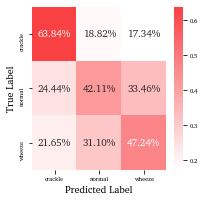

In [10]:
from sklearn.ensemble import RandomForestClassifier

class_names =  list(pd.factorize(y_train_)[1])
clf = RandomForestClassifier(criterion='entropy', max_depth=8, n_estimators=500,random_state=42)
#clf = GaussianNB()
#clf = KNeighborsClassifier(n_neighbors=4, weights='distance')


clf.fit(X_train_ , y_train_)
y_pred = clf.predict(X_test_)

f, ax = utility.plot_cm(y_test_ , y_pred, module_path = module_path, class_names = class_names)

## Syntetic dataset split on silence

In [22]:
X_train_, y_train_ = load_from_tsfile_to_dataframe(module_path + '/features/extracted_ts_files/UiT_preproject_synthetic_TRAIN.ts')
X_test_, y_test_ = load_from_tsfile_to_dataframe(module_path + '/features/extracted_ts_files/UiT_preproject_synthetic_TEST.ts')
X_val_, y_val_ = load_from_tsfile_to_dataframe(module_path +'/features/extracted_ts_files/UiT_preproject_synthetic_VAL.ts')

X_train_, X_test_, X_val_ = from_nested_to_2d_array(X_train_), from_nested_to_2d_array(X_test_), from_nested_to_2d_array(X_val_)

cols = np.arange(len(X_test_.columns))
X_train_.columns, X_test_.columns, X_val_.columns = cols, cols, cols

y_train_, y_test_, y_val_ = pd.Series(y_train_), pd.Series(y_test_), pd.Series(y_val_)


scaler = MinMaxScaler() 
scaler.fit(X_train_)
X_train_ = pd.DataFrame(scaler.transform(X_train_)) 
X_val_ = pd.DataFrame(scaler.transform(X_val_)) 
X_test_ = pd.DataFrame(scaler.transform(X_test_))

### Without EEMD 

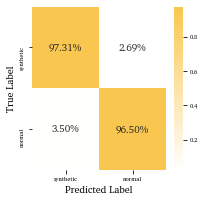

In [23]:
from sklearn.ensemble import RandomForestClassifier

class_names =  list(pd.factorize(y_train_)[1])
clf = RandomForestClassifier(criterion='entropy', max_depth=8, n_estimators=500,random_state=42)
#clf = GaussianNB()
#clf = KNeighborsClassifier(n_neighbors=4, weights='distance')


clf.fit(X_train_ , y_train_)
y_pred = clf.predict(X_test_)

f, ax = utility.plot_cm(y_test_ , y_pred, module_path = module_path, class_names = class_names, color_index = 4)

### With EEMD 

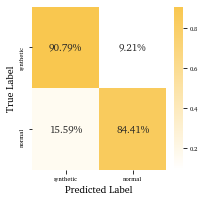

In [24]:
from sklearn.ensemble import RandomForestClassifier

class_names =  list(pd.factorize(y_train_)[1])
clf = RandomForestClassifier(criterion='entropy', max_depth=8, n_estimators=500,random_state=42)
#clf = GaussianNB()
#clf = KNeighborsClassifier(n_neighbors=4, weights='distance')


clf.fit(X_train_ , y_train_)
y_pred = clf.predict(X_test_)

f, ax = utility.plot_cm(y_test_ , y_pred, module_path = module_path, class_names = class_names, color_index = 4)